In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt

import scipy
from scipy import signal,stats
from scipy.fft import rfft,rfftfreq
from scipy import stats
from scipy.ndimage import uniform_filter1d

import seaborn as sns
import pandas as pd
import sklearn
import seaborn as sns

In [ ]:
 # # Function for loading FULL dataset

# File paths
filenames = [
    '1_250124_205115-210602_brainwaves - Antonio - LVHA - Horror movies.txt',
    '2_250124_210834-212527_brainwaves - Antonio - HVLA - Vipassana.txt',
    '3_250124_225258-230511_brainwaves - Antonio - HVLA - Vipassana after hot tub.txt'
]

# Dictionary to store data for each file
data = {
    'horror movie': [],
    'vipassana': [],
    'hot tub': []
}

# Function to load data
def load_data(file_path):
    # Load the data without a header
    data_file = pd.read_csv(file_path, header=None, delimiter=',')
    
    # Extract the 4th column (eeg data) and 5th column (timestamps)
    brainwave_data = data_file.iloc[:, 3].values  # 4th column is index 3
    timestamps = data_file.iloc[:, 4].values      # 5th column is index 4

    return brainwave_data, timestamps

# Load the data for each file
print('Data:\n')
for idx, file in enumerate(data.keys()):
    brainwave_data, timestamps = load_data(f'.../{filenames[idx]}')
    data[file] = [brainwave_data, timestamps]
    print(f'{file} Data Shape: {brainwave_data.shape}')


Data:

horror movie Data Shape: (224942,)
vipassana Data Shape: (260050,)
hot tub Data Shape: (188573,)


In [3]:
# # Set sampling frequency
fs = 256

# Apply a bandpass filter between 0.5-54 Hz to each set of data
filt_coef = signal.firwin(numtaps=(int(3*fs/4)), cutoff=(0.5,54), fs=fs, pass_zero=False)

# # Apply a bandpass filter between 0.5-54 Hz to each data set
def butter_bandpass_filter(data, lowcut, highcut, fs=fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data, axis=-1)

def notch_filter(data, freq, fs=fs, Q=10):  # Two notch filters at 50 and 60Hz
    nyquist = 0.5 * fs
    w0 = freq / nyquist
    b, a = signal.iirnotch(w0, Q)
    return signal.filtfilt(b, a, data, axis=-1)

# Combined function to apply both filters
def apply_filters(data, fs=fs):
    # Apply bandpass filter
    filtered_data = butter_bandpass_filter(data, lowcut=0.5, highcut=54, fs=fs)

    # Apply notch filters at 50 Hz and 60 Hz sequentially
    filtered_data = notch_filter(filtered_data, freq=50, fs=fs)
    filtered_data = notch_filter(filtered_data, freq=60, fs=fs)

    return filtered_data


In [ ]:
# # Create function to grab specific 5 min sections 

# def select_data_section(data_dict, file_sections, fs=256):
#     # Define number of samples for 5 minutes
#     samples_per_minute = fs * 60  # Samples in one minute
#     num_samples_5min = samples_per_minute * 5  # Samples in 5 minutes

#     # Function to select section from a single dataset
#     def select_data_section(data, timestamps, section='first'):
#         if section == 'first':
#             selected_data = data[:num_samples_5min]
#             selected_timestamps = timestamps[:num_samples_5min]
#         elif section == 'last':
#             selected_data = data[-num_samples_5min:]
#             selected_timestamps = timestamps[-num_samples_5min:]
#         else:
#             raise ValueError("Invalid section. Use 'first' or 'last'.")
#         return selected_data, selected_timestamps

#     # Extract 5-minute sections for all datasets
#     sectioned_data = {}
#     for idx, file in enumerate(data_dict.keys()):
#         raw_data, timestamps = data_dict[file]

#         # Select the section for this file
#         selected_data, selected_timestamps = select_data_section(raw_data, timestamps, section=file_sections[idx])
#         sectioned_data[file] = (selected_data, selected_timestamps)

#         print(f'{file} Selected Data Shape: {selected_data.shape}')

#     return sectioned_data

# # Example usage
# file_sections = ['first', 'last', 'last']  # Define sections to extract

# data_sectioned = select_data_section(data, file_sections) # UNFILTERED and sectioned data

# Create function to grab specific 5 min sections
def select_data_section(data_dict, file_sections, fs=256):
    # Define number of samples for time periods
    samples_per_minute = fs * 60  # Samples in one minute
    num_samples_5min = samples_per_minute * 5  # Samples in 5 minutes

    # Function to select section from a single dataset
    def select_data_section(data, timestamps, section='first'):
        if section == 'first':
            # First 5 minutes (0-5 min)
            selected_data = data[:num_samples_5min]
            selected_timestamps = timestamps[:num_samples_5min]
        elif section == 'last':
            # Last 5 minutes
            selected_data = data[-num_samples_5min:]
            selected_timestamps = timestamps[-num_samples_5min:]
        elif section == '2_to_7':
            # Minute 2 to 7 
            start_sample = samples_per_minute * 2  # Start at minute 2
            end_sample = start_sample + num_samples_5min  # End at minute 7
            selected_data = data[start_sample:end_sample]
            selected_timestamps = timestamps[start_sample:end_sample]
        else:
            raise ValueError("Invalid section. Use 'first', 'last', or '3_to_8'.")

        return selected_data, selected_timestamps

    # Extract sections for all datasets
    sectioned_data = {}
    for idx, file in enumerate(data_dict.keys()):
        raw_data, timestamps = data_dict[file]

        # Select the section for this file
        selected_data, selected_timestamps = select_data_section(
            raw_data, timestamps, section=file_sections[idx]
        )
        sectioned_data[file] = (selected_data, selected_timestamps)

        print(f'{file} Selected Data Shape: {selected_data.shape}')

    return sectioned_data

# Implement
file_sections = ['2_to_7', 'last', 'last']  # Define sections to extract

data_sectioned = select_data_section(data, file_sections)  # UNFILTERED and sectioned data



horror movie Selected Data Shape: (76800,)
vipassana Selected Data Shape: (76800,)
hot tub Selected Data Shape: (76800,)


In [5]:
# # Filter the data and grab the 5 min sections
data_filt = {}
for file in data.keys():
    brainwave_data, timestamps = data[file]
    filtered_brainwave_data = apply_filters(brainwave_data)
    data_filt[file] = (filtered_brainwave_data, timestamps)

# # Grab 5 min sections of filtered data
data_filt = select_data_section(data_filt, file_sections) # FILTERED and sectioned data

horror movie Selected Data Shape: (76800,)
vipassana Selected Data Shape: (76800,)
hot tub Selected Data Shape: (76800,)


In [6]:
# # CODE FOR SAVING DATA as .txt file *********

#np.savetxt("hot_tub_data_filtered.txt", data_filt['hot tub'][0], fmt='%0.16f')

#hmtf = pd.read_csv('D:/AWEAR/Python Notebooks/hot_tub_data_filtered.txt', header=None, delimiter=',').values.squeeze()

#print(np.allclose(hmtf, data_filt['hot tub'][0], atol=1e-12))


In [ ]:
# Create function to plot data in time and frequency domain for 5 MIN sections of dataset

def plot_time_and_frequency(data_dict, label, fs=256):

    # Create the figure and axes
    fig, axes = plt.subplots(3, 2, figsize=(16, 12))
    fig.suptitle('Time and Frequency Domain Plots for EEG Data', fontsize=16)

    # Iterate through each file and plot
    for idx, (file, (data, timestamps)) in enumerate(data_dict.items()):
        # Time vector for plotting
        t_vec = np.arange(0, len(data) / fs, 1 / fs)

        # Time Domain Plot
        ax_time = axes[idx, 0]
        ax_time.plot(t_vec, data, color='blue', linewidth=0.8)
        ax_time.set_title(f'{file.capitalize()} - Time Domain {label}')
        ax_time.set_xlabel('Time (s)')
        ax_time.set_ylabel('Amplitude (µV)')
        ax_time.set_xlim([0, 300])  # Limit to 5 minutes (300 seconds)

        # Frequency Domain Plot (Power Spectral Density)
        ax_freq = axes[idx, 1]
        freqs, psd = signal.welch(data, fs, nperseg=int(fs * 5),window='hann')  # Calculate PSD with a 5 second segment length
        ax_freq.semilogy(freqs, psd, color='red', linewidth=0.8)
        ax_freq.set_title(f'{file.capitalize()} - Frequency Domain {label}')
        ax_freq.set_xlabel('Frequency (Hz)')
        ax_freq.set_ylabel('Power')
        ax_freq.set_xlim([0, 80])  # Show full frequency range
        ax_freq.set_ylim([1e-6,1e4])

    # Adjust layout and display the plots
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the main title
    plt.show()

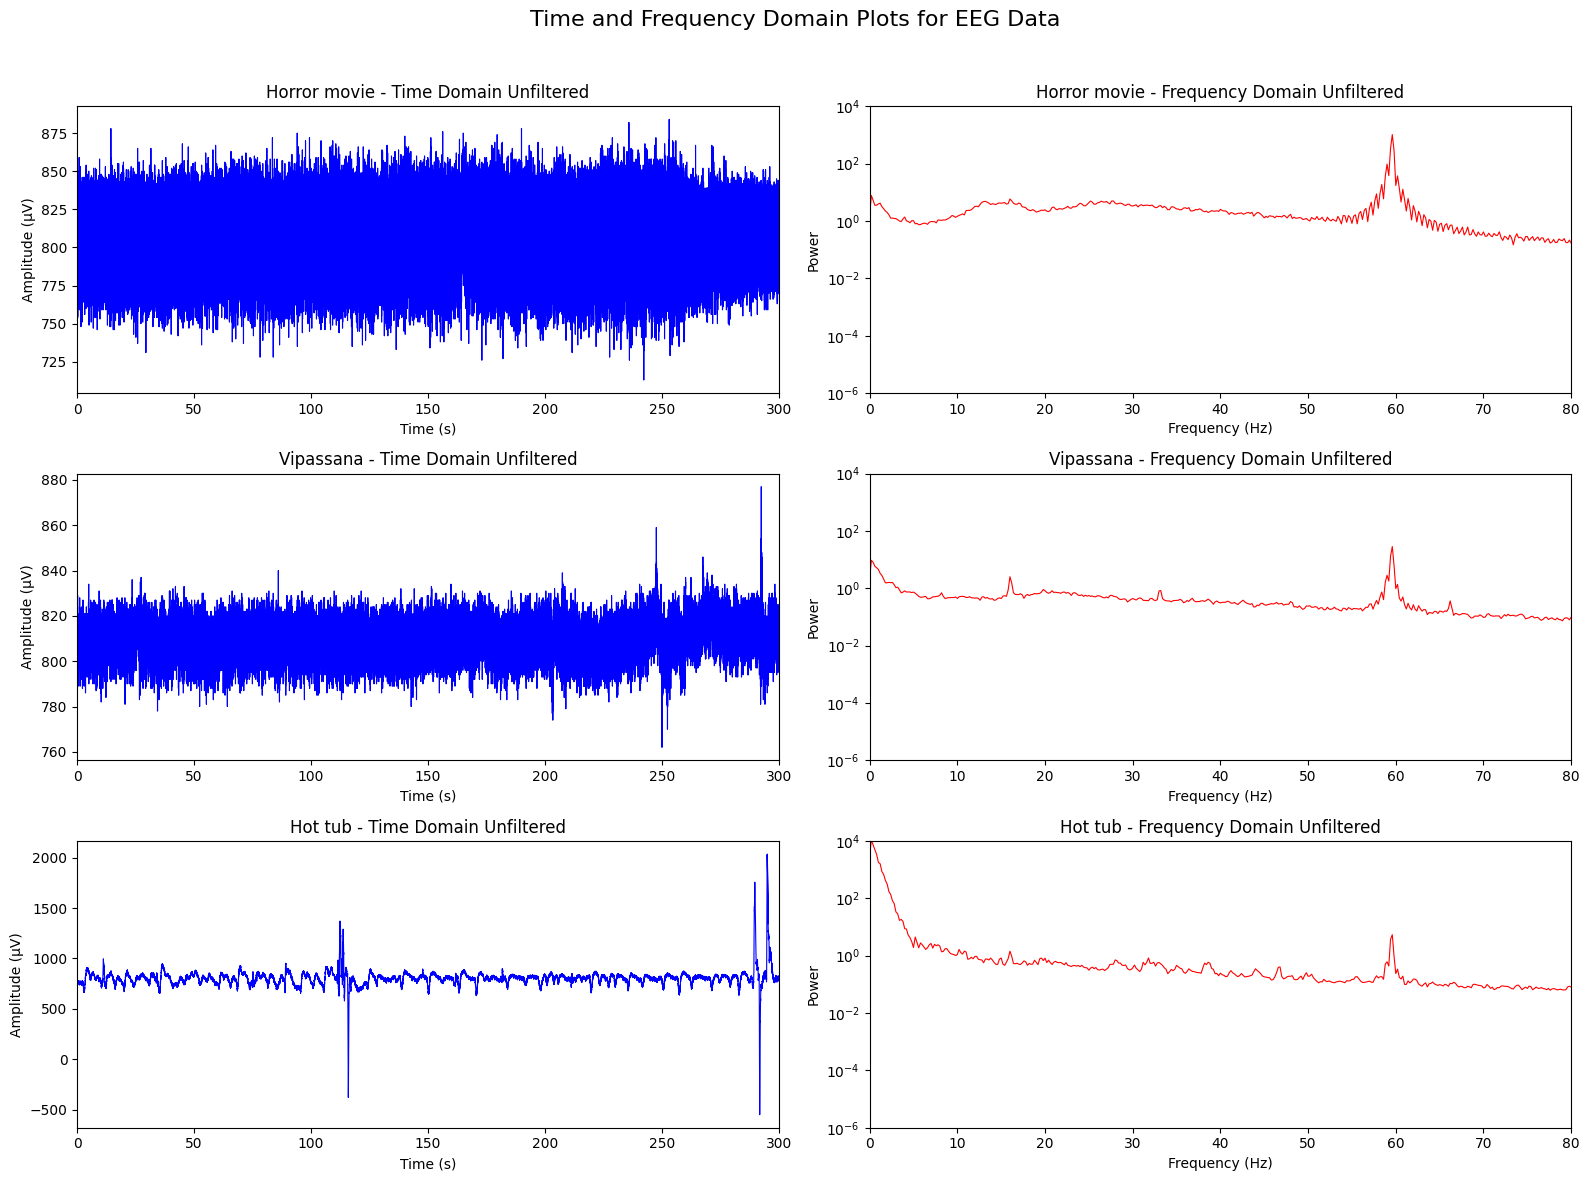

In [8]:
# # Plot the unfiltered data

plot_time_and_frequency(data_sectioned,label='Unfiltered')

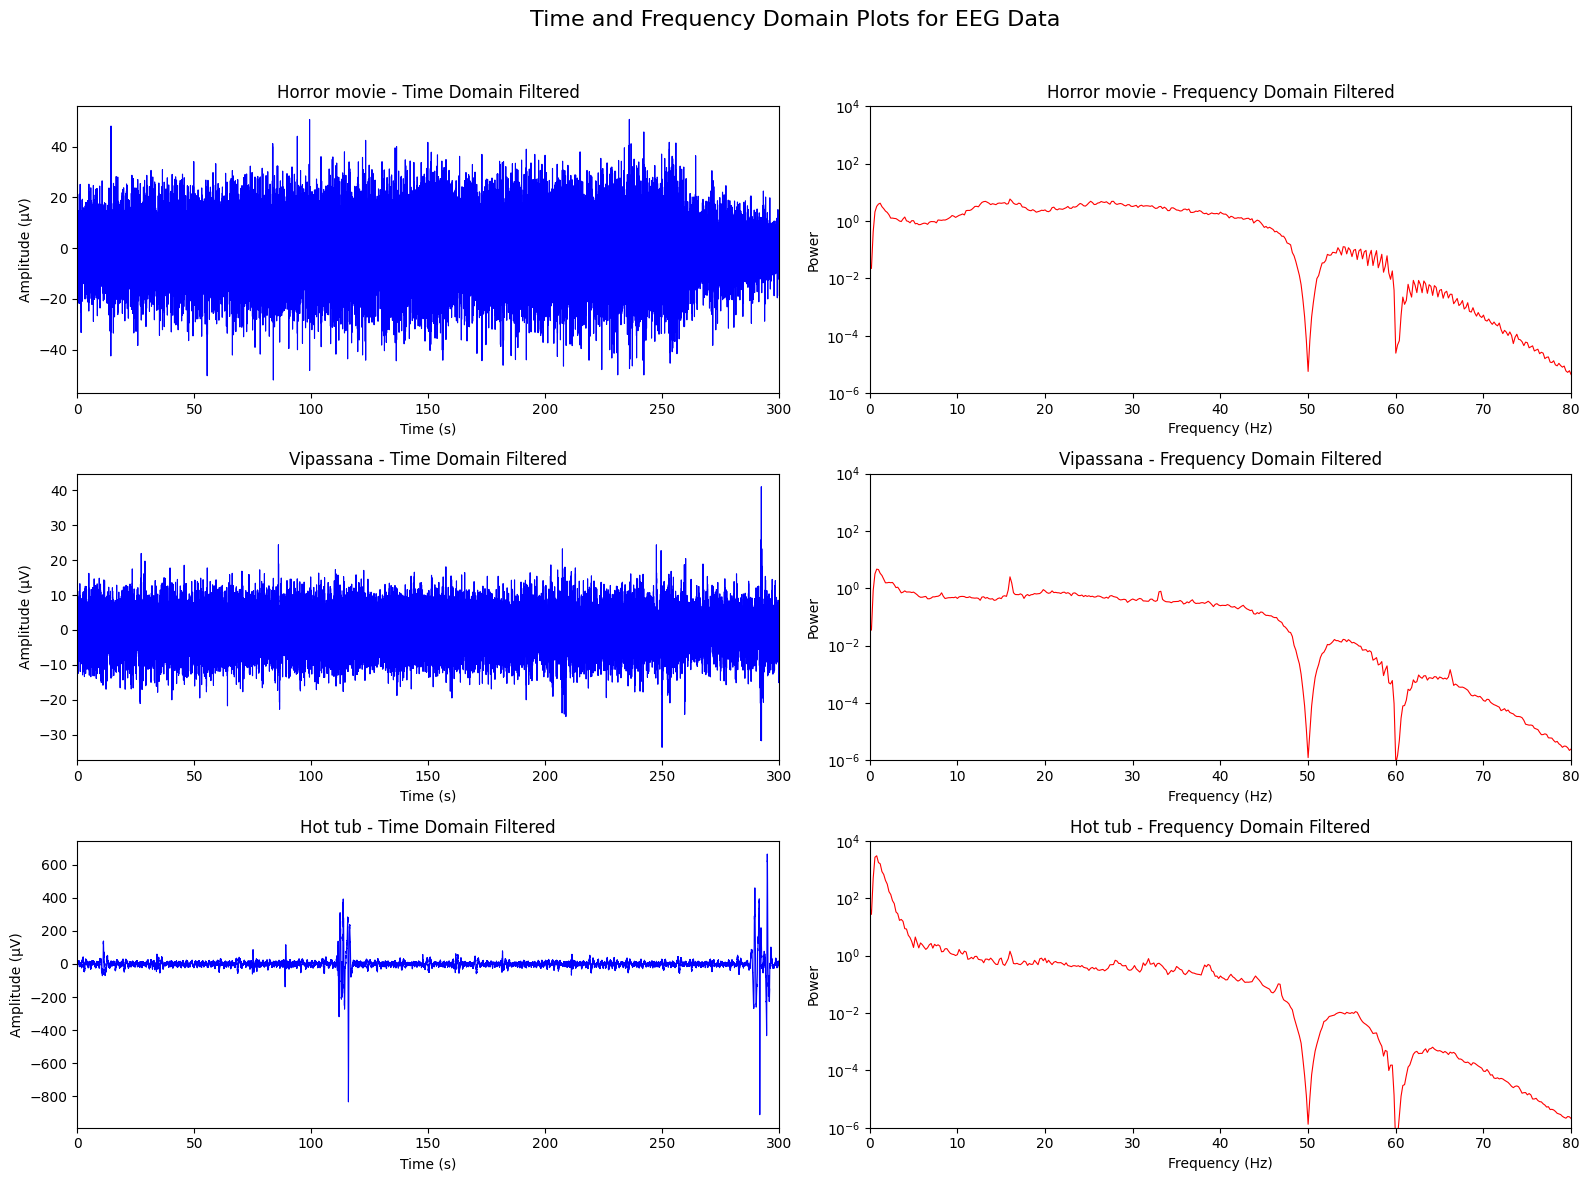

In [9]:
# # Plot the filtered data
plot_time_and_frequency(data_filt,label='Filtered')

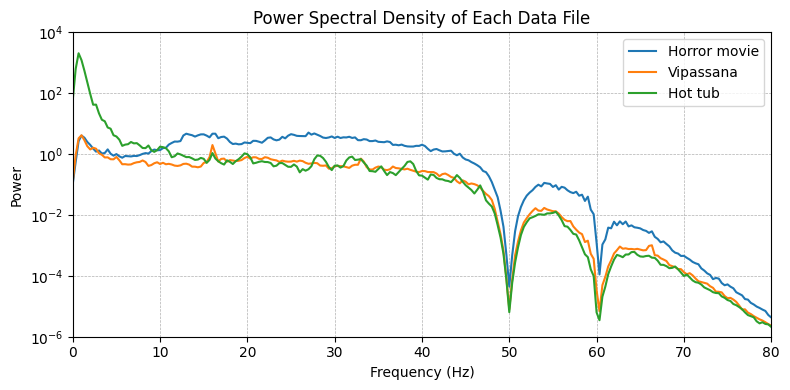

In [10]:
# # Function to plot all data files PSD together

def plot_combined_psd(data_dict, fs=256):

    plt.figure(figsize=(8,4))

    # Iterate through each file and calculate PSD
    for file, (data, _) in data_dict.items():
        freqs, psd = signal.welch(data, fs, nperseg=int(fs*3),noverlap=int(fs*0.25) ,window='hann')
        plt.semilogy(freqs, psd, linewidth=1.5, label=f'{file.capitalize()}')

    # Set plot properties
    plt.title('Power Spectral Density of Each Data File')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.xlim([0, 80])
    plt.ylim([1e-6, 1e4])
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

plot_combined_psd(data_filt)


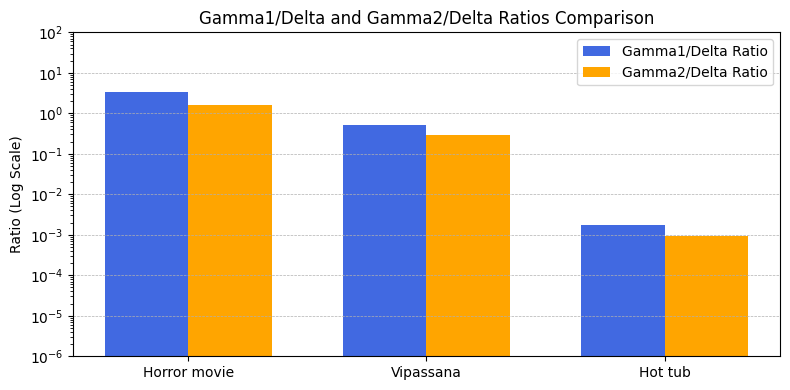

In [ ]:
# # Bar plot comparison of gamma1/delta and gamma2/delta ratios for each 3 datasets

# Function to calculate total power values for specific frequency band
def calculate_band_power(psd, freqs, band_range):
    band_mask = (freqs >= band_range[0]) & (freqs <= band_range[1])
    return np.sum(psd[band_mask])

# Function to calculate the power values for specific band ratios 
def calculate_ratios(data_dict, fs=256):
    ratios = {}
    for file, (data, _) in data_dict.items():
        freqs, psd = signal.welch(data, fs, nperseg=int(fs),noverlap=int(fs*0.25) ,window='hann')

        delta_range = (0.5, 4)
        gamma1_range = (30, 38)
        gamma2_range = (38, 46)

        delta_power = calculate_band_power(psd, freqs, delta_range)
        gamma1_power = calculate_band_power(psd, freqs, gamma1_range)
        gamma2_power = calculate_band_power(psd, freqs, gamma2_range)

        gamma1_ratio = gamma1_power / delta_power if delta_power != 0 else 0
        gamma2_ratio = gamma2_power / delta_power if delta_power != 0 else 0

        ratios[file] = (gamma1_ratio, gamma2_ratio)

    return ratios#, print(f'freqs shape{freqs.shape}',f'psd shape{psd.shape}')

# Plot the results as a bar plot
def plot_ratios_bar(ratios):
    files = list(ratios.keys())
    gamma1_ratios = [ratios[file][0] for file in files]
    gamma2_ratios = [ratios[file][1] for file in files]

    x = np.arange(len(files))
    width = 0.35

    plt.figure(figsize=(8,4))
    plt.bar(x - width/2, gamma1_ratios, width, label='Gamma1/Delta Ratio', color='royalblue')
    plt.bar(x + width/2, gamma2_ratios, width, label='Gamma2/Delta Ratio', color='orange')

    #plt.xlabel('Condition')
    plt.ylabel('Ratio (Log Scale)')
    plt.title('Gamma1/Delta and Gamma2/Delta Ratios Comparison')
    plt.ylim([1e-6,1e2])
    plt.xticks(x, [file.capitalize() for file in files])
    plt.legend()
    plt.yscale('log') 
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

    
# Display results
ratios = calculate_ratios(data_filt)
plot_ratios_bar(ratios)


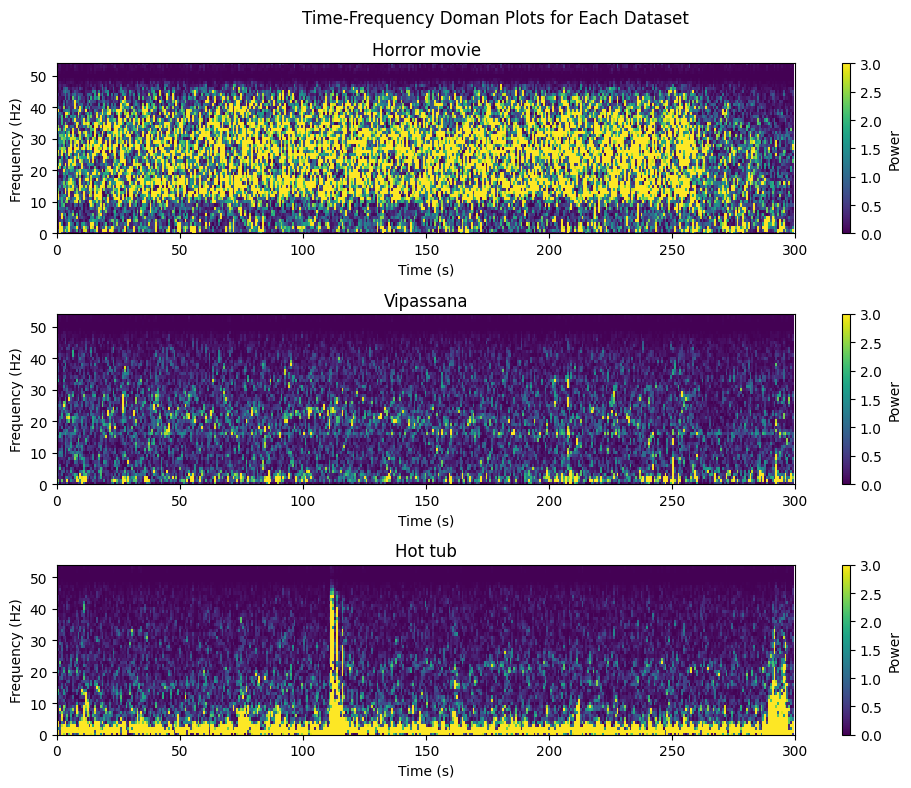

In [ ]:
# # Create function to plot the time-frequency representations of each plot

def plot_time_frequency(data_dict, fs=256, vmax_dict=None):
    fig, axes = plt.subplots(3, 1, figsize=(10,8))
    fig.suptitle('Time-Frequency Doman Plots for Each Dataset')

    for idx, (file, (data, _)) in enumerate(data_dict.items()):
        # Extract spectrogram values 
        f, t, Sxx = signal.spectrogram(data, fs, nperseg=int(fs), noverlap=int(fs * 0.25), window='hann')

        # Create option for selecting specific vmax vlues
        vmax = vmax_dict[file] if vmax_dict and file in vmax_dict else None

        # Plot results
        im = axes[idx].pcolormesh(t, f, Sxx, shading='auto', cmap='viridis', vmax=vmax,vmin=0)
        axes[idx].set_title(f'{file.capitalize()}')
        axes[idx].set_ylabel('Frequency (Hz)')
        axes[idx].set_xlabel('Time (s)')
        axes[idx].set_xlim([0, len(data) / fs])
        axes[idx].set_ylim([0,54])

        fig.colorbar(im, ax=axes[idx], orientation='vertical', label='Power')

    plt.tight_layout()
    plt.show()

# Choose best vmax values for visualizing results
vmax_values = {
    'horror movie': 3,
    'vipassana': 3,
    'hot tub': 3
}

plot_time_frequency(data_filt, vmax_dict=vmax_values)


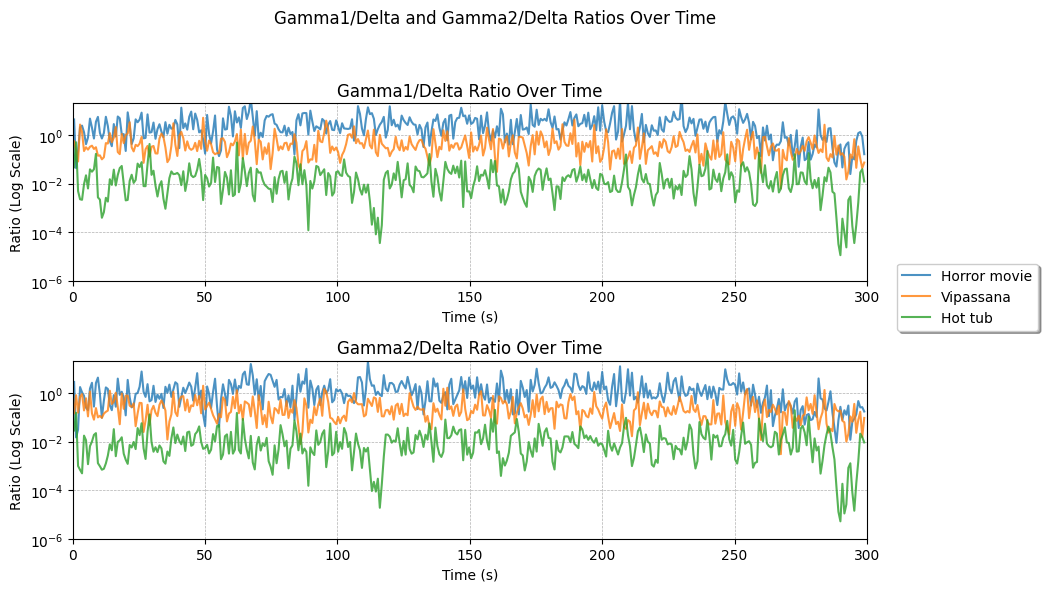

In [ ]:
# # Create function to plot gamma1/delta and gamma2/delta ratios across time 

def plot_separate_gamma_delta_ratios(data_dict, fs=256, min_value=1e-6):
    freq_ranges = {
        'delta': (0.5, 4),
        'gamma1': (30, 38),
        'gamma2': (38, 46)
    }

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
    fig.suptitle('Gamma1/Delta and Gamma2/Delta Ratios Over Time')

    for file, (data, _) in data_dict.items():
        f, t, spg = signal.spectrogram(data, fs, nperseg=int(fs), noverlap=int(fs * 0.25), window='hann')

        band_powers = {}
        # Extract the mean of the power values for a specific frequency range at each time step
        for band, (f_min, f_max) in freq_ranges.items():
            band_mask = np.logical_and(f >= f_min, f <= f_max)
            band_powers[band] = spg[band_mask].mean(axis=0)

        # Ensure each plot gets the correct data
        gamma1_delta_ratio = np.maximum(band_powers['gamma1'] / band_powers['delta'], min_value)
        gamma2_delta_ratio = np.maximum(band_powers['gamma2'] / band_powers['delta'], min_value)

        ax1.plot(t, gamma1_delta_ratio, label=f'{file.capitalize()}', linestyle='-', alpha=0.8)
        ax2.plot(t, gamma2_delta_ratio, label=f'{file.capitalize()}', linestyle='-', alpha=0.8)

    # Gamma1/Delta plot settings
    ax1.set_title('Gamma1/Delta Ratio Over Time')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Ratio (Log Scale)')
    ax1.set_xlim([0, t[-1] + 1])
    ax1.set_ylim([min_value, 1e1+10])
    ax1.set_yscale('log')
    ax1.grid(True, linestyle='--', linewidth=0.5)

    # Gamma2/Delta plot settings
    ax2.set_title('Gamma2/Delta Ratio Over Time')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Ratio (Log Scale)')
    ax2.set_xlim([0, t[-1] + 1])
    ax2.set_ylim([min_value, 1e1+10])  
    ax2.set_yscale('log')
    ax2.grid(True, linestyle='--', linewidth=0.5)

    # Single legend for both plots
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.05, 0.5), shadow=True)

    plt.tight_layout(rect=[0, 0, 0.9, 0.94])
    plt.show()

# Run the function
plot_separate_gamma_delta_ratios(data_filt)

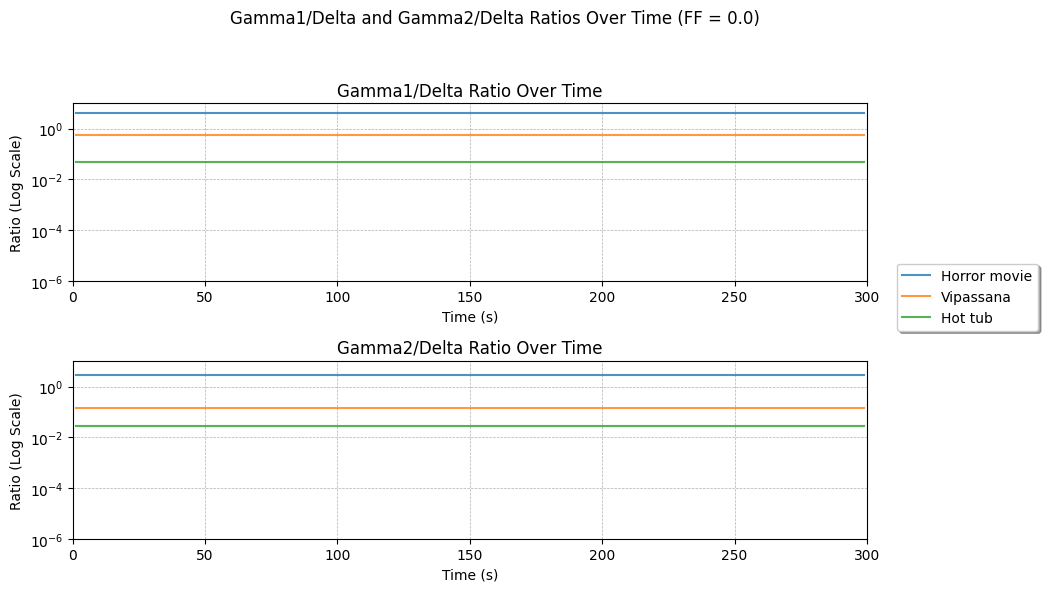

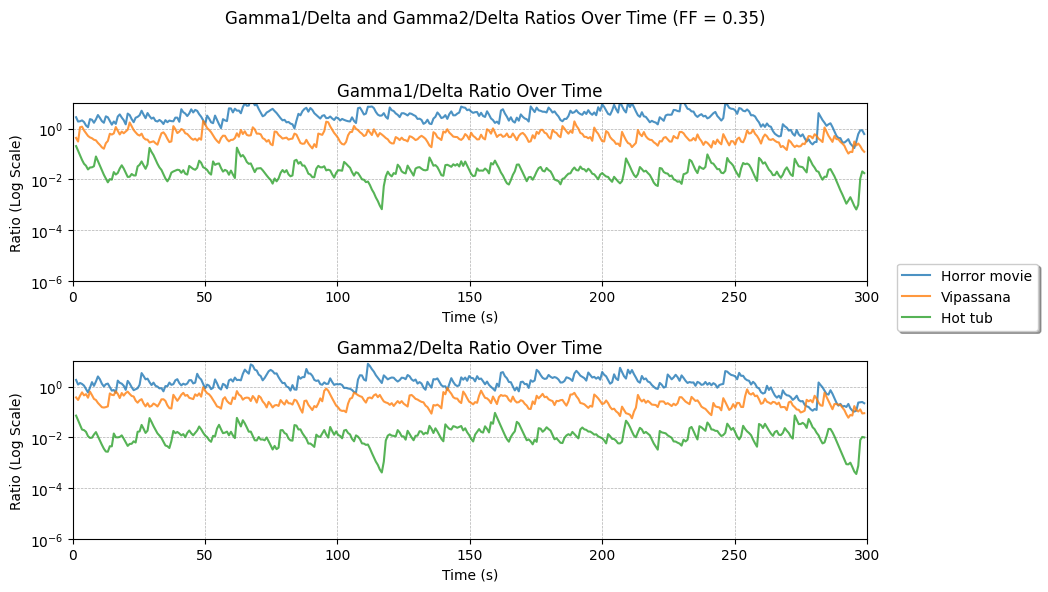

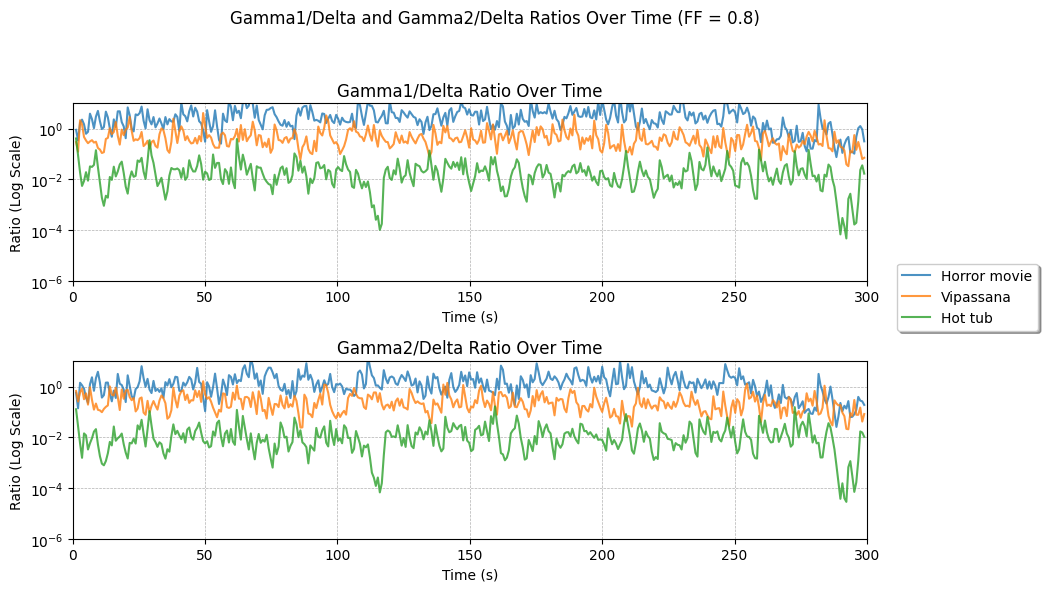

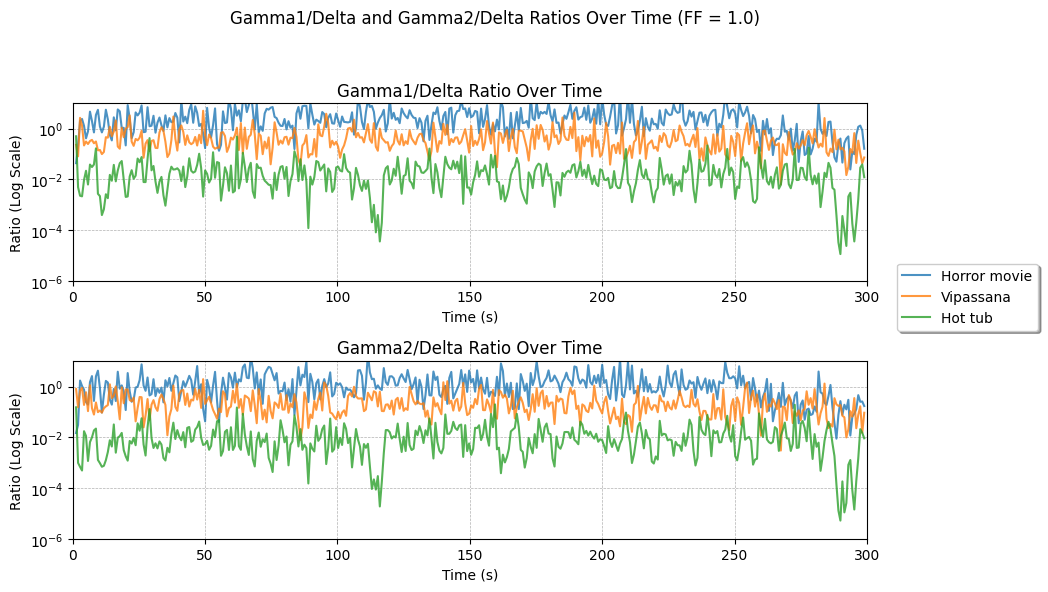

In [ ]:
# # Apply forgetting factor to previous plot (gamma/delta ratios over time)

# Modified function to include forgetting factor
def plot_gamma_delta_ratios_with_ff(data_dict, fs=256, min_value=1e-6, FF=0.5):
    freq_ranges = {
        'delta': (0.5, 4),
        'gamma1': (30, 38),
        'gamma2': (38, 46)
    }

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6))
    fig.suptitle(f'Gamma1/Delta and Gamma2/Delta Ratios Over Time (FF = {FF})')

    for file, (data, _) in data_dict.items():
        f, t, spg = signal.spectrogram(data, fs, nperseg=int(fs), noverlap=int(fs * 0.25), window='hann')

        band_powers = {}
        for band, (f_min, f_max) in freq_ranges.items():
            band_mask = np.logical_and(f >= f_min, f <= f_max)
            band_powers[band] = spg[band_mask].mean(axis=0)

        # Initial values for the forgetting factor formula
        gamma1_ratio_unsmoothed = band_powers['gamma1'] / band_powers['delta']
        gamma2_ratio_unsmoothed = band_powers['gamma2'] / band_powers['delta']

        # Initialize smoothed values with the first data point
        smoothed_gamma1 = gamma1_ratio_unsmoothed[0]
        smoothed_gamma2 = gamma2_ratio_unsmoothed[0]

        # Arrays to store the Smoothed Values over time
        smoothed_gamma1_series = []
        smoothed_gamma2_series = []

        # Apply forgetting factor formula iteratively, start from 1
        for i in range(1, len(t)):
            smoothed_gamma1 = (1 - FF) * smoothed_gamma1 + FF * gamma1_ratio_unsmoothed[i]
            smoothed_gamma2 = (1 - FF) * smoothed_gamma2 + FF * gamma2_ratio_unsmoothed[i]
            smoothed_gamma1_series.append(smoothed_gamma1)
            smoothed_gamma2_series.append(smoothed_gamma2)

        
        smoothed_gamma1_series = np.maximum(smoothed_gamma1_series, min_value)
        smoothed_gamma2_series = np.maximum(smoothed_gamma2_series, min_value)

        ax1.plot(t[1:], smoothed_gamma1_series, label=f'{file.capitalize()}', linestyle='-', alpha=0.8)
        ax2.plot(t[1:], smoothed_gamma2_series, label=f'{file.capitalize()}', linestyle='-', alpha=0.8)

    
    ax1.set_title('Gamma1/Delta Ratio Over Time')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Ratio (Log Scale)')
    ax1.set_xlim([0, t[-1] + 1])
    ax1.set_ylim([min_value, 1e1])
    ax1.set_yscale('log')
    ax1.grid(True, linestyle='--', linewidth=0.5)

    # Gamma2/Delta plot settings
    ax2.set_title('Gamma2/Delta Ratio Over Time')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Ratio (Log Scale)')
    ax2.set_xlim([0, t[-1] + 1])
    ax2.set_ylim([min_value, 1e1])
    ax2.set_yscale('log')
    ax2.grid(True, linestyle='--', linewidth=0.5)

    
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.05, 0.5), shadow=True)

    plt.tight_layout(rect=[0, 0, 0.9, 0.94])
    plt.show()

for FF in [0.0, 0.35, 0.8, 1.0]:
    plot_gamma_delta_ratios_with_ff(data_filt, FF=FF)


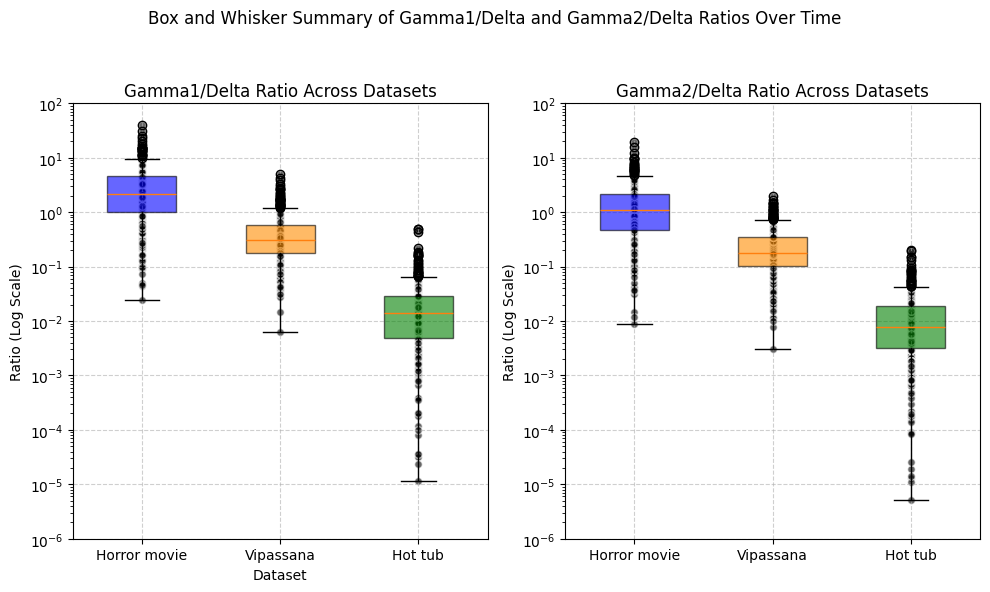

f shape(129,) t shape(399,)


In [ ]:
# # Box and whisker plot summarizing results

def plot_gamma_delta_ratios_box(data_dict, fs=256, min_value=1e-6):
    freq_ranges = {
        'delta': (0.5, 4),
        'gamma1': (30, 38),
        'gamma2': (38, 46)
    }

    colors = ['blue', 'darkorange', 'green']
    all_gamma1_delta_ratios = []
    all_gamma2_delta_ratios = []
    dataset_labels = []

    for file, (data, _) in data_dict.items():
        # Extract spectrogram values
        f, t, spg = signal.spectrogram(data, fs, nperseg=int(fs), noverlap=int(fs * 0.25), window='hann')

        # Extract average power value for each frequency band 
        band_powers = {}
        for band, (f_min, f_max) in freq_ranges.items():
            band_mask = np.logical_and(f >= f_min, f <= f_max)
            band_powers[band] = spg[band_mask].mean(axis=0)

        gamma1_delta_ratio = np.maximum(band_powers['gamma1'] / band_powers['delta'], min_value)
        gamma2_delta_ratio = np.maximum(band_powers['gamma2'] / band_powers['delta'], min_value)

        all_gamma1_delta_ratios.append(gamma1_delta_ratio)
        all_gamma2_delta_ratios.append(gamma2_delta_ratio)
        dataset_labels.append(file.capitalize())

    fig, axes = plt.subplots(1, 2, figsize=(10,6))
    fig.suptitle('Box and Whisker Summary of Gamma1/Delta and Gamma2/Delta Ratios Over Time')

    # Gamma1/Delta Plot
    bp1 = axes[0].boxplot(all_gamma1_delta_ratios, patch_artist=True, tick_labels=dataset_labels, widths=0.5)
    for patch, color in zip(bp1['boxes'], colors):
        patch.set(facecolor=color, alpha=0.6)
    axes[0].set_title('Gamma1/Delta Ratio Across Datasets')
    axes[0].set_xlabel('Dataset')
    axes[0].set_ylabel('Ratio (Log Scale)')
    axes[0].set_yscale('log')
    #axes[0].set_ylim([1e-3, 20])
    axes[0].set_ylim([1e-6, 1e2])
    axes[0].grid(True, linestyle='--', alpha=0.6)

    for i, ratios in enumerate(all_gamma1_delta_ratios):
        axes[0].scatter(
            [i + 1] * len(ratios), ratios, color='black', alpha=0.6, s=30, edgecolors='white'
        )

    # Gamma2/Delta Plot
    bp2 = axes[1].boxplot(all_gamma2_delta_ratios, patch_artist=True, tick_labels=dataset_labels, widths=0.5)
    for patch, color in zip(bp2['boxes'], colors):
        patch.set(facecolor=color, alpha=0.6)
    axes[1].set_title('Gamma2/Delta Ratio Across Datasets')
    #axes[1].set_xlabel('Dataset')
    axes[1].set_ylabel('Ratio (Log Scale)')
    axes[1].set_yscale('log')
    axes[1].set_ylim([1e-6,1e2])
    #axes[1].set_ylim([1e-3, 20])

    axes[1].grid(True, linestyle='--', alpha=0.6)

    for i, ratios in enumerate(all_gamma2_delta_ratios):
        axes[1].scatter(
            [i + 1] * len(ratios), ratios, color='black', alpha=0.6, s=30, edgecolors='white'
        )

    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()

    return print(f'f shape{f.shape}',f't shape{t.shape}')


plot_gamma_delta_ratios_box(data_filt)



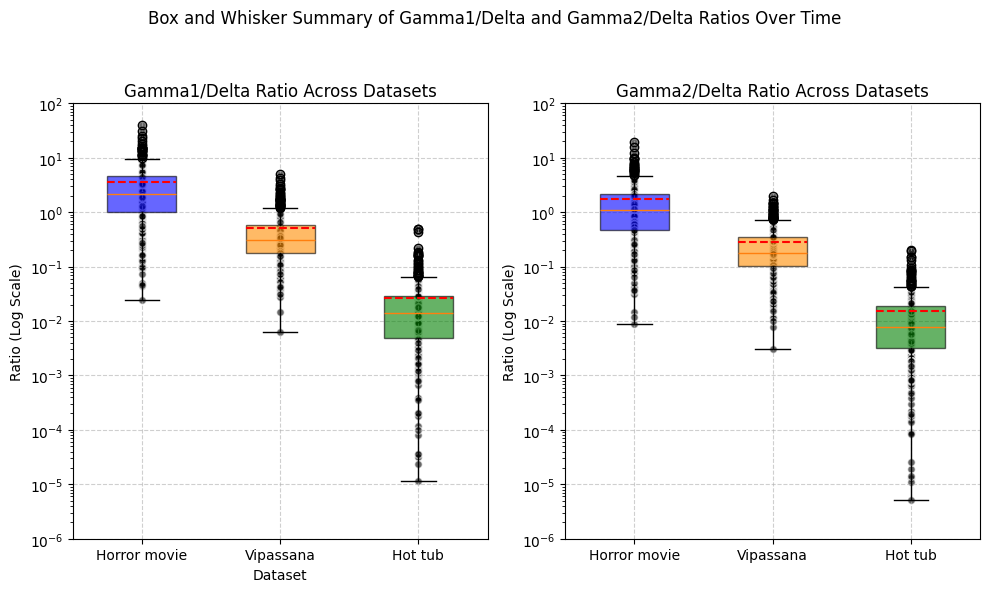

In [ ]:
def plot_gamma_delta_ratios_box_with_mean(data_dict, fs=256, min_value=1e-6):

    freq_ranges = {
        'delta': (0.5, 4),
        'gamma1': (30, 38),
        'gamma2': (38, 46)
    }

    colors = ['blue', 'darkorange', 'green']
    all_gamma1_delta_ratios = []
    all_gamma2_delta_ratios = []
    dataset_labels = []

    for file, (data, _) in data_dict.items():
        # Compute spectrogram
        f, t, spg = signal.spectrogram(data, fs, nperseg=int(fs), noverlap=int(fs * 0.25), window='hann')

        # Extract power in frequency bands
        band_powers = {}
        for band, (f_min, f_max) in freq_ranges.items():
            band_mask = np.logical_and(f >= f_min, f <= f_max)
            band_powers[band] = spg[band_mask].mean(axis=0)

        # Calculate ratios
        gamma1_delta_ratio = np.maximum(band_powers['gamma1'] / band_powers['delta'], min_value)
        gamma2_delta_ratio = np.maximum(band_powers['gamma2'] / band_powers['delta'], min_value)

        # Store results
        all_gamma1_delta_ratios.append(gamma1_delta_ratio)
        all_gamma2_delta_ratios.append(gamma2_delta_ratio)
        dataset_labels.append(file.capitalize())

    fig, axes = plt.subplots(1, 2, figsize=(10, 6))
    fig.suptitle('Box and Whisker Summary of Gamma1/Delta and Gamma2/Delta Ratios Over Time')

    # Gamma1/Delta Plot
    bp1 = axes[0].boxplot(all_gamma1_delta_ratios, patch_artist=True, tick_labels=dataset_labels, widths=0.5)
    for patch, color in zip(bp1['boxes'], colors):
        patch.set(facecolor=color, alpha=0.6)
    axes[0].set_title('Gamma1/Delta Ratio Across Datasets')
    axes[0].set_xlabel('Dataset')
    axes[0].set_ylabel('Ratio (Log Scale)')
    axes[0].set_yscale('log')
    axes[0].set_ylim([1e-6, 1e2])
    axes[0].grid(True, linestyle='--', alpha=0.6)

    # Add scatter points for all data points
    for i, ratios in enumerate(all_gamma1_delta_ratios):
        axes[0].scatter(
            [i + 1] * len(ratios), ratios, color='black', alpha=0.6, s=30, edgecolors='white'
        )

    # Add mean line to Gamma1/Delta plot
    for i, ratios in enumerate(all_gamma1_delta_ratios):
        mean_value = np.mean(ratios)
        axes[0].hlines(y=mean_value, xmin=i + 0.75, xmax=i + 1.25, colors='red', linestyles='dashed', label='Mean' if i == 0 else None)

    # Gamma2/Delta Plot
    bp2 = axes[1].boxplot(all_gamma2_delta_ratios, patch_artist=True, tick_labels=dataset_labels, widths=0.5)
    for patch, color in zip(bp2['boxes'], colors):
        patch.set(facecolor=color, alpha=0.6)
    axes[1].set_title('Gamma2/Delta Ratio Across Datasets')
    axes[1].set_ylabel('Ratio (Log Scale)')
    axes[1].set_yscale('log')
    axes[1].set_ylim([1e-6, 1e2])
    axes[1].grid(True, linestyle='--', alpha=0.6)

    # Add scatter points for all data points
    for i, ratios in enumerate(all_gamma2_delta_ratios):
        axes[1].scatter(
            [i + 1] * len(ratios), ratios, color='black', alpha=0.6, s=30, edgecolors='white'
        )

    # Add mean line to Gamma2/Delta plot
    for i, ratios in enumerate(all_gamma2_delta_ratios):
        mean_value = np.mean(ratios)
        axes[1].hlines(y=mean_value, xmin=i + 0.75, xmax=i + 1.25, colors='red', linestyles='dashed', label='Mean' if i == 0 else None)

    # Add legend for the mean line
    handles, labels = axes[1].get_legend_handles_labels()
    if 'Mean' not in labels:
        axes[1].legend(loc='upper right', fontsize='small')

    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()


# Call the function
plot_gamma_delta_ratios_box_with_mean(data_filt)

# Lempel-Zic Compression (LZC) Analysis

In [ ]:
# # Implementing code on Lempel-Zic Compression (LZC)
'''
LZC measures how complex or random a signal is.
High LZC = More random, chaotic signal (e.g., aroused or noisy brain state).
Low LZC = More structured, repetitive signal (e.g., calm, relaxed state).
'''

def calculate_lzc(data):
    # Convert EEG data to a binary sequence
    # Use the median value of the data as a threshold to create binary data (0s and 1s)
    threshold = np.median(data)
    binary_seq = (data > threshold).astype(int)

    # Convert the binary sequence to a string
    binary_str = ''.join(binary_seq.astype(str))

    # Implement the Lempel-Ziv complexity algorithm
    n = len(binary_str)
    i, lzc_count, k, sub_str_len = 0, 1, 1, 1  # Initializing parameters

    while i + k < n:
        # Check if the substring of length k is a repeated pattern
        substring = binary_str[i:i + k + 1]

        # If substring is found earlier in the string, continue expanding it
        if binary_str[:i + k].find(substring) != -1:
            k += 1
        else:
            # If not found, it's a new pattern
            lzc_count += 1
            i += k  # Move to next position
            k = 1  # Reset substring length

    # Normalize the LZC value
    # Use log scaling to normalize based on sequence length
    norm_factor = n / np.log2(n) if n > 1 else 1
    lzc_value = lzc_count / norm_factor

    return lzc_value

# Function to implement LZC
def apply_lzc_to_data(data_dict):
    lzc_results = {}
    for file, (filtered_data, _) in data_dict.items():
        lzc_value = calculate_lzc(filtered_data)
        lzc_results[file] = lzc_value
        print(f'LZC for {file}: {lzc_value:.4f}')
    
    return lzc_results

# Apply LZC analysis to the Filtered data
lzc_results = apply_lzc_to_data(data_filt)


# Ground Truth for Unfiltered data from antonio's email
# disp(horrordata_chaos_avg) %lzc = 0.4769
# disp(vipassanadata_chaos_avg) %lzc = 0.9141
# disp(hottubdata_chaos_avg) %lzc = 0.2844



LZC for horror movie: 0.6969
LZC for vipassana: 0.6589
LZC for hot tub: 0.2910


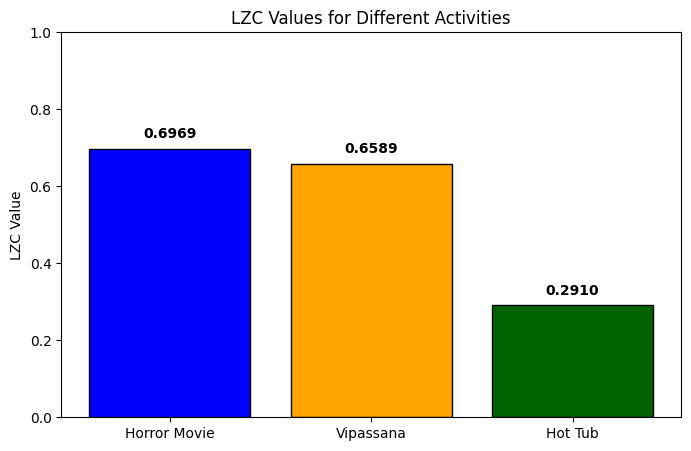

In [18]:
# LZC values for different activities
activities = ['Horror Movie', 'Vipassana', 'Hot Tub']
lzc_values = [0.6969, 0.6589, 0.2910]

# Plotting the bar diagram
plt.figure(figsize=(8, 5))
colors = ['blue', 'orange','darkgreen']
plt.bar(activities, lzc_values, color=colors, edgecolor='black')

# Adding labels and title
#plt.xlabel('Activity')
plt.ylabel('LZC Value')
plt.title('LZC Values for Different Activities')
plt.ylim(0, 1)  # Setting the y-axis range to provide context for values

# Adding the exact values on top of each bar
for i, value in enumerate(lzc_values):
    plt.text(i, value + 0.02, f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

# Display the plot
plt.show()


In [19]:
# # LZC Function that is similar to UCSF team .m file

def preprocess_data(data):
    return data - np.mean(data)

def redefine_trials(data, fs=256, trial_length=4, overlap=0.5):
    samples_per_trial = int(fs * trial_length)
    step_size = int(samples_per_trial * (1 - overlap))
    trials = [data[i:i + samples_per_trial]
        for i in range(0, len(data) - samples_per_trial + 1, step_size)]
    
    return np.array(trials)

def apply_hanning_window(trials):
    window = np.hanning(trials.shape[1])
    return trials * window

def calculate_lzc(data):
    threshold = np.mean(data)
    binary_seq = (data > threshold).astype(int)
    binary_str = ''.join(binary_seq.astype(str))

    n = len(binary_str)
    i, lzc_count, k = 0, 1, 1

    while i + k < n:
        substring = binary_str[i:i + k + 1]
        if binary_str[:i + k].find(substring) != -1:
            k += 1
        else:
            lzc_count += 1
            i += k
            k = 1

    norm_factor = n / np.log2(n) if n > 1 else 1
    return lzc_count / norm_factor

def calculate_lzc_trials(trials):
    lzc_values = [calculate_lzc(trial) for trial in trials]
    return np.mean(lzc_values)

def apply_lzc_analysis(data_dict, fs=256):
    lzc_results = {}
    for file, (data, _) in data_dict.items():
        data_demeaned = preprocess_data(data)
        trials = redefine_trials(data_demeaned, fs=fs)
        trials_windowed = apply_hanning_window(trials)
        lzc_value = calculate_lzc_trials(trials_windowed)
        lzc_results[file] = lzc_value
        print(f'LZC for {file}: {lzc_value:.4f}')
    return lzc_results


lzc_results = apply_lzc_analysis(data)


LZC for horror movie: 0.5671
LZC for vipassana: 0.8773
LZC for hot tub: 0.2255


# Appendix

In [20]:
# # # Load Data
# filenames = ['1_250124_205115-210602_brainwaves - Antonio - LVHA - Horror movies.txt',
#               '2_250124_210834-212527_brainwaves - Antonio - HVLA - Vipassana.txt', 
#               '3_250124_225258-230511_brainwaves - Antonio - HVLA - Vipassana after hot tub.txt'] 

# data = {'horror movie':[],
#         'vipassana':[],
#         'hot tub':[]}


# def load_data(file_path):
#     data_file = pd.read_csv(file_path, header=None, delimiter=',')
#     # Extract the 4th column (brainwave data) and 5th column (timestamps)
#     brainwave_data = data_file.iloc[:, 3].values  # 4th column is index 3
#     timestamps = data_file.iloc[:, 4].values      # 5th column is index 4

#     return brainwave_data, timestamps

# # Load the data for each file
# print('Data:\n')
# for idx, file in enumerate(data.keys()):
#     brainwave_data, timestamps = load_data(f'D:/AWEAR/Data Files/UCSF Data/{filenames[idx]}')
#     data[file] = [brainwave_data, timestamps]
#     print(f'{file} data shape: {brainwave_data.shape}')

###########################################################################################################

# # Function for loading data and indexing 5 min sections right away

# # Define sampling frequency and number of samples for 5 minutes
# fs = 256  # Sampling rate in Hz
# samples_per_minute = fs * 60  # Samples in one minute
# num_samples_5min = samples_per_minute * 5  # Samples in 5 minutes

# # Initialize the data dictionary
# data = {
#     'horror movie': [],
#     'vipassana': [],
#     'hot tub': []
# }

# def load_data(file_path, section='first'):
#     """
#     Loads data from a file and selects a 5-minute section.

#     Parameters:
#     - file_path: Path to the data file
#     - section: Which section to extract ('first' or 'last')
    
#     Returns:
#     - Selected brainwave data and timestamps for the specified section
#     """
#     # Read the file without a header
#     data_file = pd.read_csv(file_path, header=None, delimiter=',')

#     # Extract the 4th column (brainwave data) and 5th column (timestamps)
#     brainwave_data = data_file.iloc[:, 3].values
#     timestamps = data_file.iloc[:, 4].values

#     # Select the appropriate 5-minute section
#     if section == 'first':
#         selected_data = brainwave_data[:num_samples_5min]
#         selected_timestamps = timestamps[:num_samples_5min]
#     elif section == 'last':
#         selected_data = brainwave_data[-num_samples_5min:]
#         selected_timestamps = timestamps[-num_samples_5min:]
#     else:
#         raise ValueError("Invalid section. Use 'first' or 'last'.")

#     return selected_data, selected_timestamps

# # Load the data for each file with the specified section
# print('Data:\n')
# file_sections = ['first', 'last', 'last']  # Sections for each file
# filenames = [
#     '1_250124_205115-210602_brainwaves - Antonio - LVHA - Horror movies.txt',
#     '2_250124_210834-212527_brainwaves - Antonio - HVLA - Vipassana.txt',
#     '3_250124_225258-230511_brainwaves - Antonio - HVLA - Vipassana after hot tub.txt'
# ]

# for idx, file in enumerate(data.keys()):
#     brainwave_data, timestamps = load_data(f'D:/AWEAR/Data Files/UCSF Data/{filenames[idx]}', section=file_sections[idx])
#     data[file] = [brainwave_data, timestamps]
#     print(f'{file} data shape: {brainwave_data.shape}')


###########################################################################################################


# Time and frequency plotting function that does NOT grab 5 min chunks, runs as is

# def plot_time_and_frequency(data_dict, label, fs=256):

#     # Create the figure and axes
#     fig, axes = plt.subplots(3, 2, figsize=(16, 12))
#     fig.suptitle('Time and Frequency Domain Plots for EEG Data', fontsize=16)

#     # Iterate through each file and plot
#     for idx, (file, (data, timestamps)) in enumerate(data_dict.items()):
#         # Time vector for plotting
#         t_vec = np.arange(0, len(data) / fs, 1 / fs)

#         # Time Domain Plot
#         ax_time = axes[idx, 0]
#         ax_time.plot(t_vec, data, color='blue', linewidth=0.8)
#         ax_time.set_title(f'{file.capitalize()} - Time Domain {label}')
#         ax_time.set_xlabel('Time (s)')
#         ax_time.set_ylabel('Amplitude (µV)')
#         ax_time.set_xlim([0, 300])  # Limit to 5 minutes (300 seconds)

#         # Frequency Domain Plot (Power Spectral Density)
#         ax_freq = axes[idx, 1]
#         freqs, psd = signal.welch(data, fs, nperseg=int(fs * 5),window='hann')  # Calculate PSD with a 5-second segment length
#         ax_freq.semilogy(freqs, psd, color='red', linewidth=0.8)
#         ax_freq.set_title(f'{file.capitalize()} - Frequency Domain {label}')
#         ax_freq.set_xlabel('Frequency (Hz)')
#         ax_freq.set_ylabel('Power')
#         ax_freq.set_xlim([0, 80])  # Show full frequency range
#         ax_freq.set_ylim([1e-6,1e10])

#     # Adjust layout and display the plots
#     plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the main title
#     plt.show()
